## ODYSEA Swath Simulator Examples

This notebook contains examples for constructing an ODYSEA orbital swath, co-locating model data, and adding expected instrument errors.

These simplified simulations are part of a much larger WaCM simulation capability at JPL, where the actual instrument, sampling, and science performance are generated.

Want to contrubite? Please do! Ask wineteer@jpl.nasa.gov how to get involved.

## Imports and classes

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from odysim.swath_sampling import OdyseaSwath
from odysim.errors import OdyseaErrors
from odysim.colocate_model import GriddedModel, addTimeDim
from odysim.utils import makePlot

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import datetime
import itertools
import xarray as xr

font = {'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

matplotlib.rc('font', **font)
matplotlib.rc('lines',linewidth=4)
matplotlib.rc('text',usetex=False)

matplotlib.rcParams.update({"axes.grid" : True, "grid.color": "black"})

## Initialize the ODYSEA swath object
Orbit_fname contains an orbit propagated using the orbit height in the filename.
config_fname most importantly contains the swath width to be used for swath generation. A swath is generated and centered on the propagated orbit nadir point.

In [10]:
odysea = OdyseaSwath(orbit_fname='../orbit_files/orbit_out_2020_2023_height590km.npz',
                     config_fname='../odysim/wacm_sampling_config.py')

## Create an orbit generator object between two dates
Note that the provided orbit is currently 2020-2023 at 590 km height in a 4AM/PM sun-synchronous orbit.

In [11]:
start_time = datetime.datetime.strptime('2020-01-22:12','%Y-%M-%d:%H')
end_time = datetime.datetime.strptime('2020-01-25:12','%Y-%M-%d:%H')

orbits = odysea.getOrbits(start_time = start_time,end_time = end_time)

## Grab the first xarray dataset orbit
The orbit iterator we created above contains all orbits that exist between the two chosen start/end dates. 
Actual orbital swath data is generated on the fly whenever next() is called. A for/while loop can also be used to iterate through each orbit inside the orbits iterator.
Each orbit swath will be returned as an xarray dataset containing information about sample time/lat/lon and antenna pointing information.
Orbital swath data are gridded in a satellite-following along/across track coordinate system, with each grid cell having an associated lat/lon/time of sampling. 

In [12]:
%%time
o = next(orbits)
display(o)

<xarray.Dataset>
Dimensions:         (along_track: 8706, cross_track: 334)
Coordinates:
  * along_track     (along_track) int64 0 1 2 3 4 5 ... 8701 8702 8703 8704 8705
  * cross_track     (cross_track) int64 0 1 2 3 4 5 ... 328 329 330 331 332 333
Data variables:
    sample_time     (along_track, cross_track) datetime64[ns] 2020-01-22T20:3...
    lat             (along_track, cross_track) float32 -79.02 -79.05 ... -81.85
    lon             (along_track, cross_track) float32 1.74 1.567 ... 4.81 5.125
    swath_blanking  (cross_track) bool True True True True ... True True True
    encoder_fore    (along_track, cross_track) float64 -90.0 -83.72 ... 90.0
    encoder_aft     (along_track, cross_track) float64 -90.0 -96.28 ... 90.0
    azimuth_fore    (along_track, cross_track) float64 -90.0 -83.72 ... -46.51
    azimuth_aft     (along_track, cross_track) float64 -90.0 -96.28 ... -46.51
    bearing         (along_track) float64 9.095e-06 -83.34 ... -136.6 -136.5
Attributes: (12/14)
    title:                Odysea Simple Orbit Sampling V0.1
    project:              Odysea
    summary:              Simplified orbit sampling assuming basic Odysea orb...
    references:           Rodriguez 2018, Wineteer 2020
    institution:          Jet Propulsion Laboratory (JPL)
    creator_name:         Alexander Wineteer
    ...                   ...
    geospatial_lat_min:   -89.99N
    geospatial_lat_max:   89.99N
    geospatial_lon_min:   -180.00E
    geospatial_lon_max:   180.00E
    time_coverage_start:  2020-01-22 20:37:00.000878
    time_coverage_end:    2020-01-22 22:11:58.873014

CPU times: user 14.1 s, sys: 111 ms, total: 14.2 s
Wall time: 14.2 s


## Look at various variables in the orbital swath data
Each orbit starts near the south-pole, passes north through the equator, through the north-pole, south through the equator, and finally ends back at the south pole.

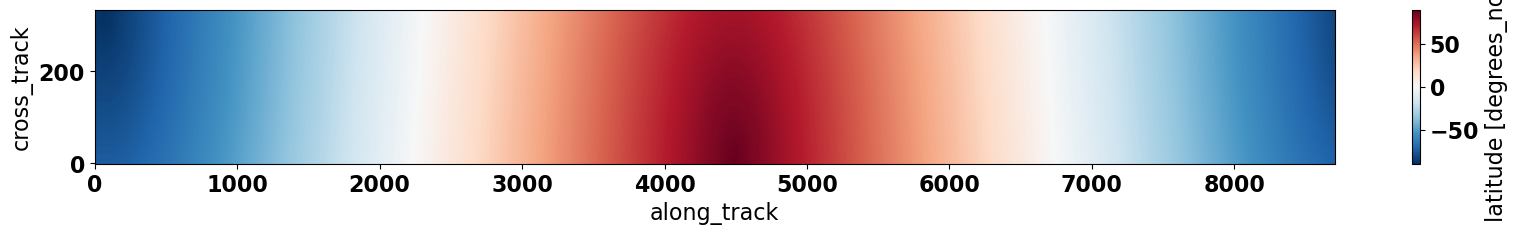

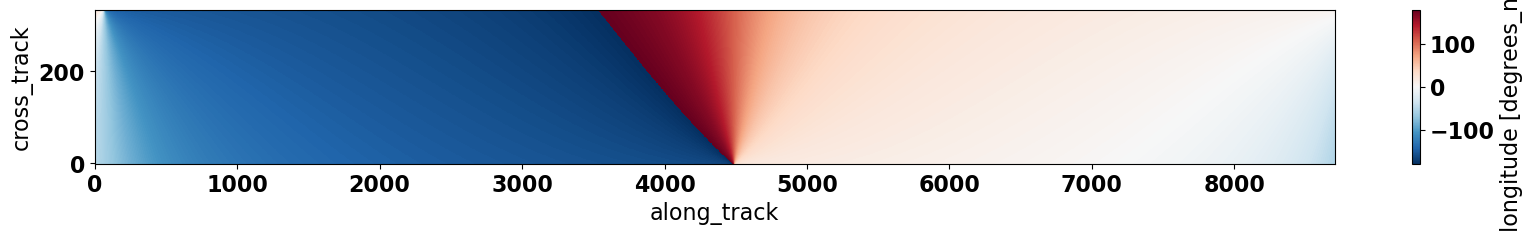

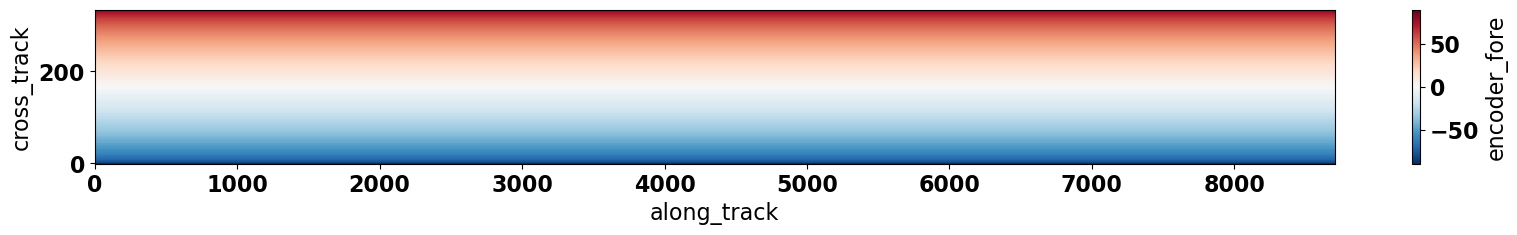

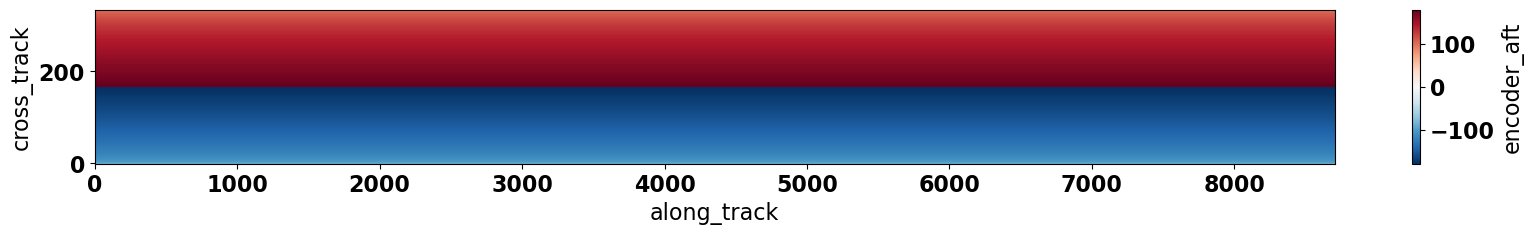

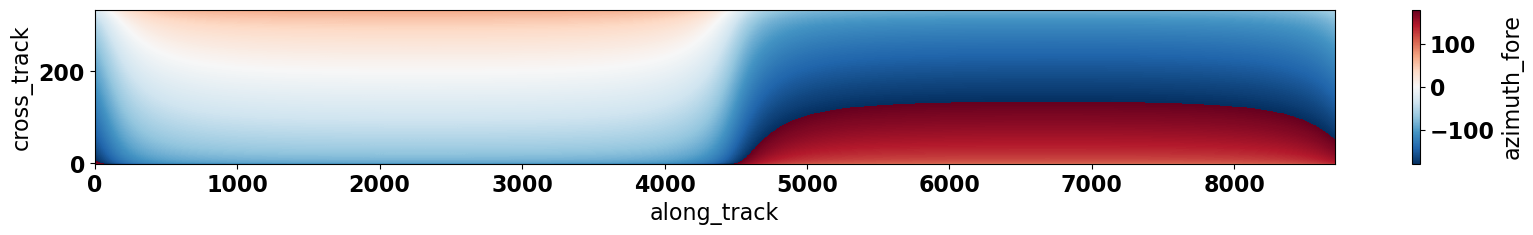

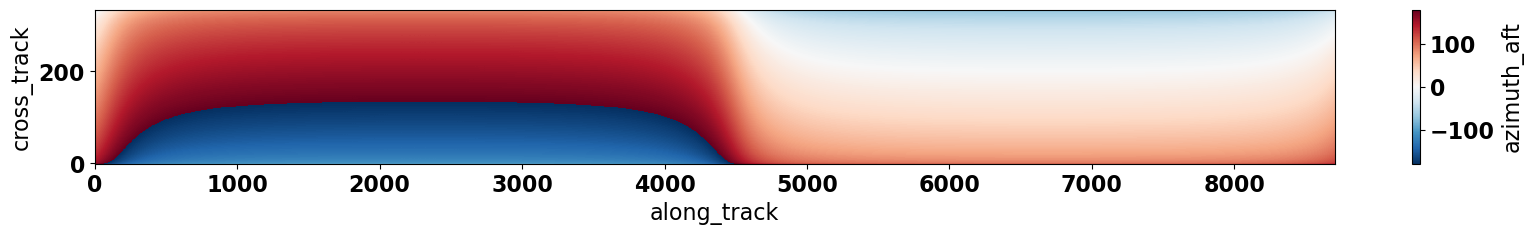

In [13]:
# plot latitude
o.lat.T.plot(figsize=(20,2))

# plot longtiude
o.lon.T.plot(figsize=(20,2))

# plot forward looking encoder angle (angle of the antenna relative to forward)
o.encoder_fore.T.plot(figsize=(20,2))

# plot backward looking encoder angle (angle of the antenna relative to forward)
o.encoder_aft.T.plot(figsize=(20,2))

# plot forward looking azimuth angle (angle of the antenna relative to North)
o.azimuth_fore.T.plot(figsize=(20,2))

# plot backward looking encoder angle (angle of the antenna relative to North)
o.azimuth_aft.T.plot(figsize=(20,2))

## Look at these data on a geographic map

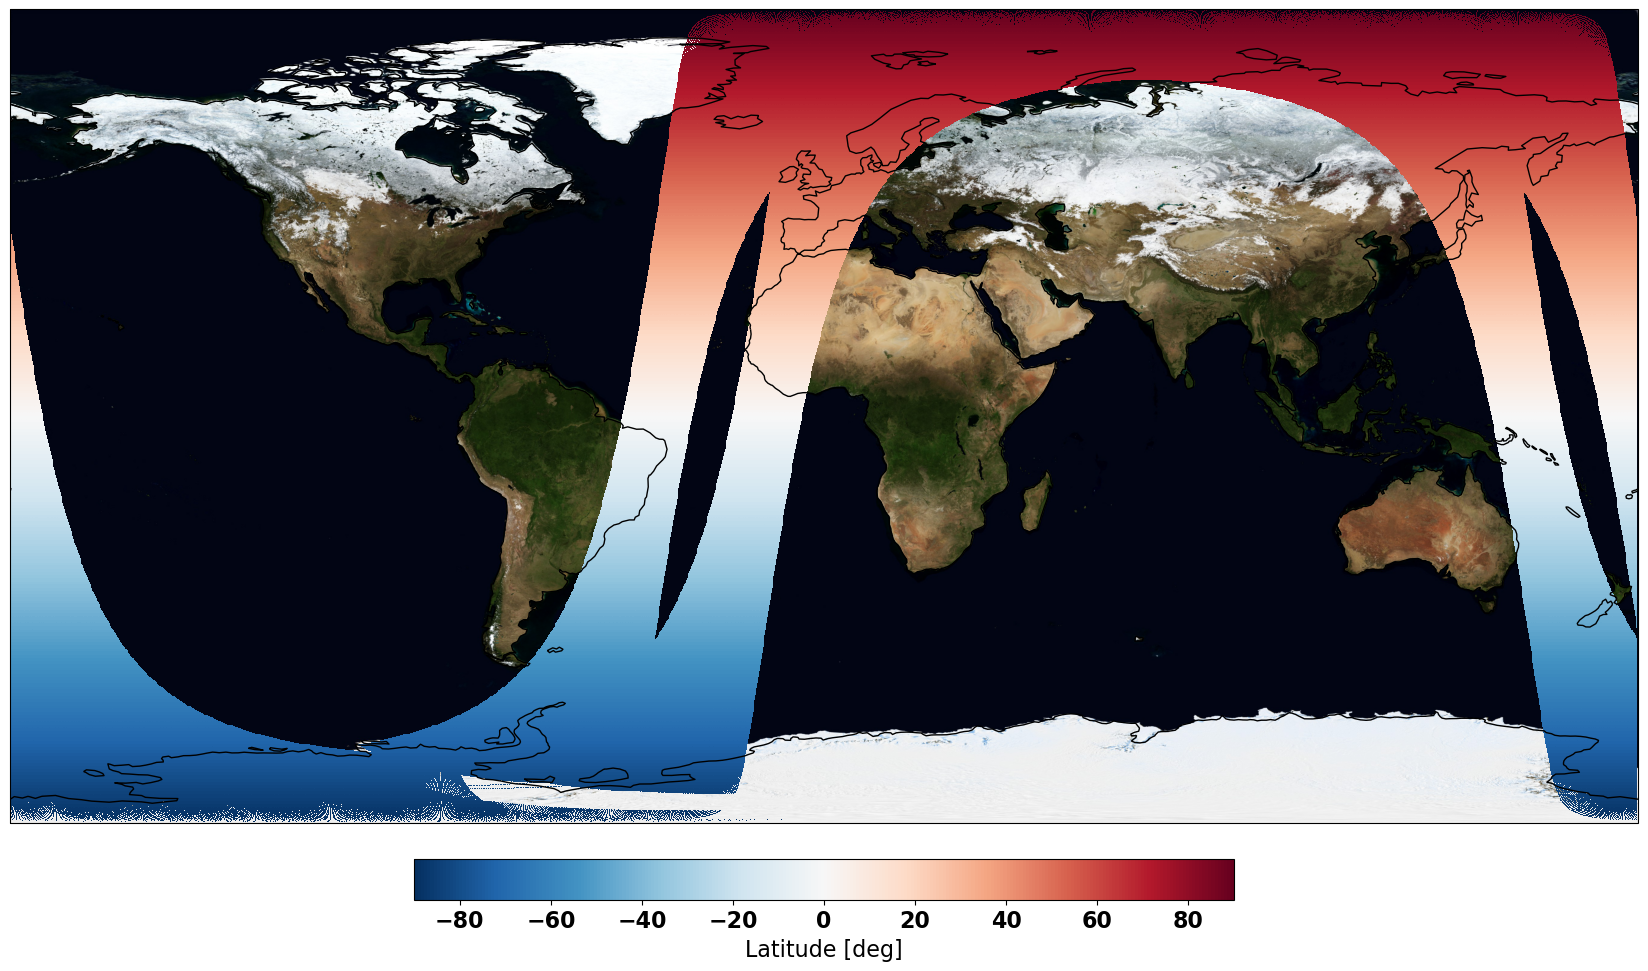

In [14]:
lons = []
lats = []

# stack up some data from 2 orbits
for o in itertools.islice(orbits, 2):    

    lons = np.append(lons,o.lon)
    lats = np.append(lats,o.lat)

# make a map with utils.makePlot(); this will grid data for us.
makePlot(lons,lats,lats,vmin=-90,vmax=90,cblabel='Latitude [deg]',colormap='RdBu_r',figsize=(20,10),bg=True,gridMe=True)

## Using swath blanking
The center and edges of the swath will be blanked in ODYSEA data due to very large uncertainties in those regions. The swath_blanking variable contains the cross-track regions to be blanked (with settings in config file). This should be broadcast along track for use. Areas marked "True" or '1' are blanked.

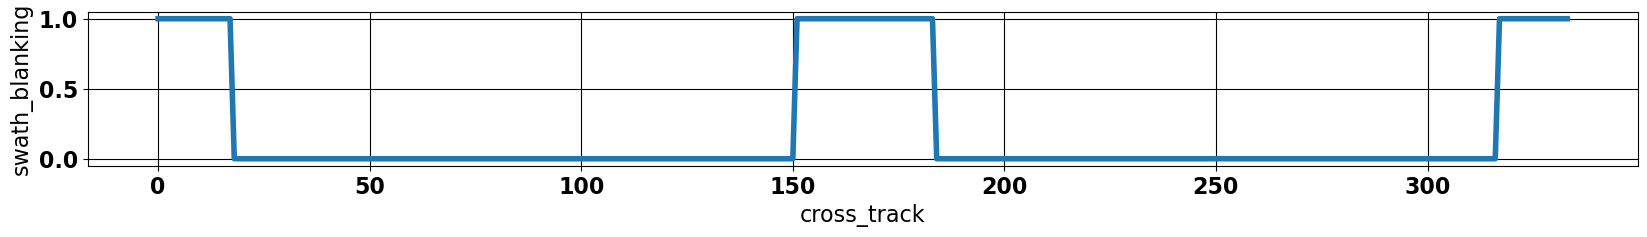

In [21]:
o.swath_blanking.plot(figsize=(20,2))

## Plot a blanked variable

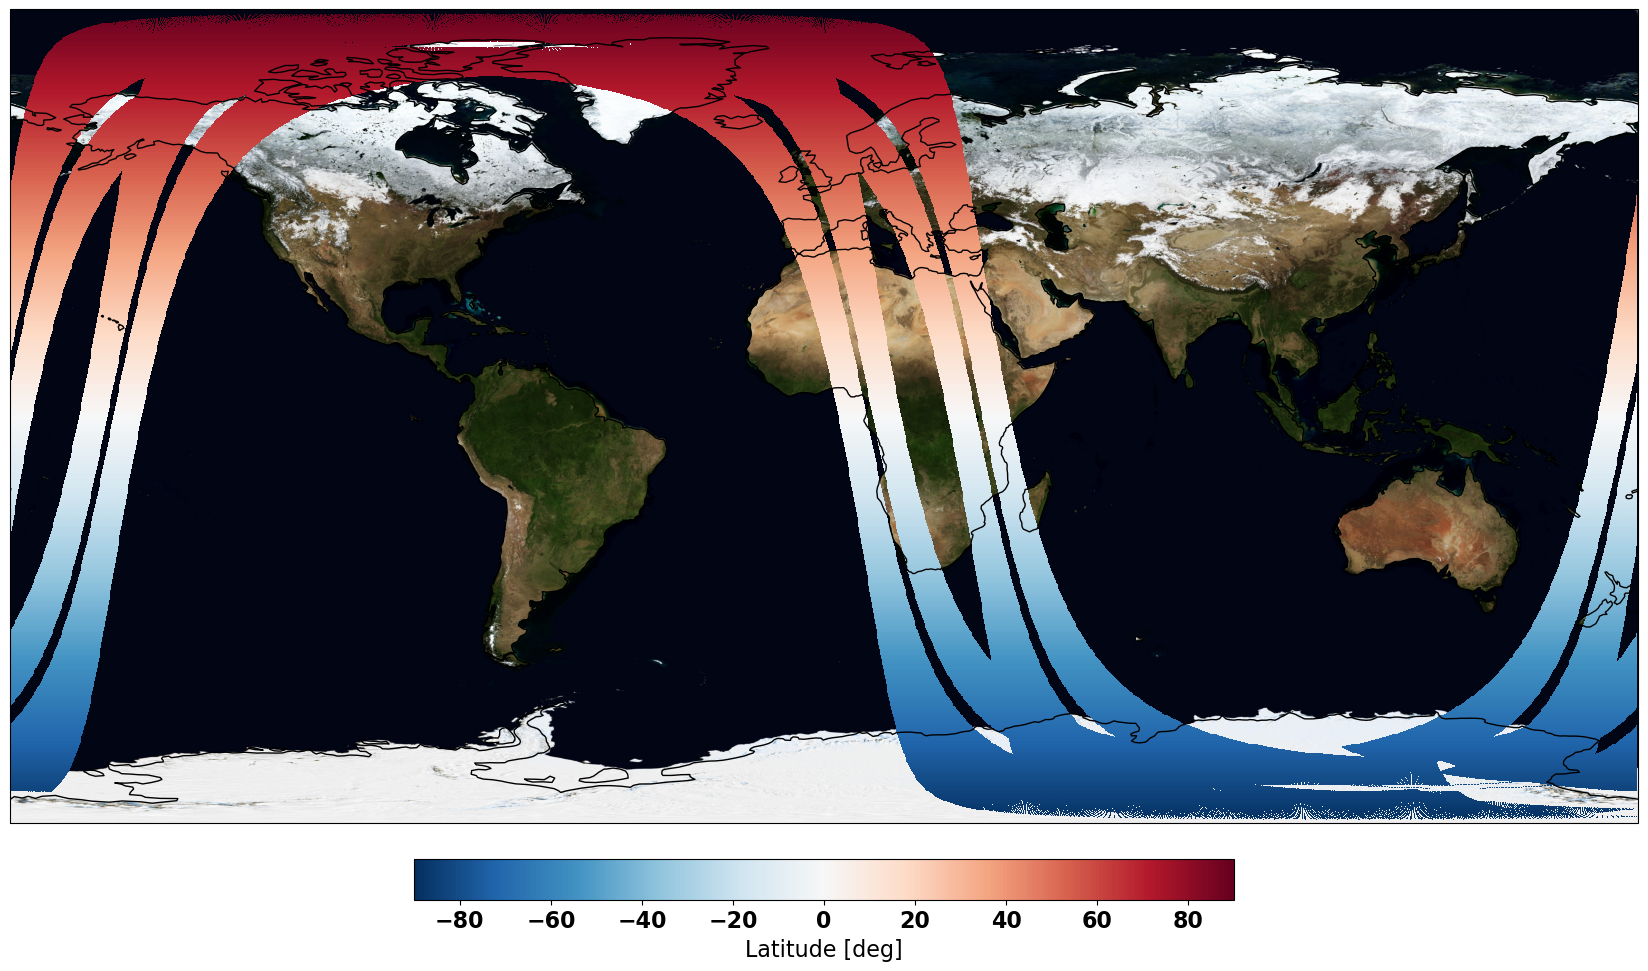

In [20]:
lons = []
lats = []
var_to_plot = []

# stack up some data from 2 orbits
for o in itertools.islice(orbits, 2):    

    lons = np.append(lons,o.lon)
    lats = np.append(lats,o.lat)
    
    lats_blanked = o.lat.values.copy()
    sb,_ = xr.broadcast(o.swath_blanking,o.lat) # broadcast the swath blanking variable to the shape of lat
    lats_blanked[sb.T==True] = np.nan
    
    var_to_plot = np.append(var_to_plot,lats_blanked)


# make a map with utils.makePlot(); this will grid data for us.
makePlot(lons,lats,var_to_plot,vmin=-90,vmax=90,cblabel='Latitude [deg]',colormap='RdBu_r',figsize=(20,10),bg=True,gridMe=True)